# Heart Disease Prediction — Improved pipeline

This notebook loads the dataset, performs EDA, cleaning, feature engineering, handles class imbalance, trains multiple models with hyperparameter tuning, evaluates them, and saves the best pipelines and a results summary.

Run cells sequentially. Created by ChatGPT per your request.

In [20]:

import pandas as pd
df = pd.read_csv('final.csv')
print('Loaded shape:', df.shape)
df.head()

Loaded shape: (319795, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [21]:
# EDA
import numpy as np
print(df.dtypes.value_counts())
print('\nSummary stats:')
display(df.describe(include='all'))
print('\nMissing values:')
print(df.isnull().sum())


target_col = 'HeartDisease'
print('Target ->', target_col)
print(df[target_col].value_counts())

object     14
float64     4
Name: count, dtype: int64

Summary stats:


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795,319795.000000,319795,319795,319795,319795.00000,319795.000000,319795,319795,319795,319795,319795,319795,319795,319795.000000,319795,319795,319795
unique,2,NaN,2,2,2,NaN,NaN,2,2,13,6,4,2,5,NaN,2,2,2
top,No,NaN,No,No,No,NaN,NaN,No,Female,65-69,White,No,Yes,Very good,NaN,No,No,No
freq,292422,NaN,187887,298018,307726,NaN,NaN,275385,167805,34151,245212,269653,247957,113858,NaN,276923,308016,289976
mean,NaN,28.325399,NaN,NaN,NaN,3.37171,3.898366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.097075,NaN,NaN,NaN
std,NaN,6.356100,NaN,NaN,NaN,7.95085,7.955235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.436007,NaN,NaN,NaN
min,NaN,12.020000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,24.030000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN
50%,NaN,27.340000,NaN,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN
75%,NaN,31.420000,NaN,NaN,NaN,2.00000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN



Missing values:
HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64
Target -> HeartDisease
HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64


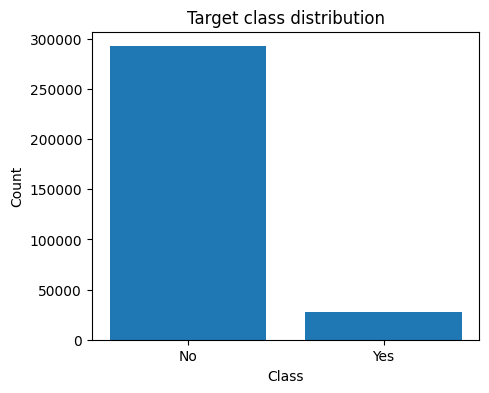

In [22]:
# Class distribution plot
import matplotlib.pyplot as plt
counts = df[target_col].value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title('Target class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Before balancing: 292422 27373
After balancing:
HeartDisease
No     27373
Yes    27373
Name: count, dtype: int64
After balancing:
HeartDisease
No     27373
Yes    27373
Name: count, dtype: int64


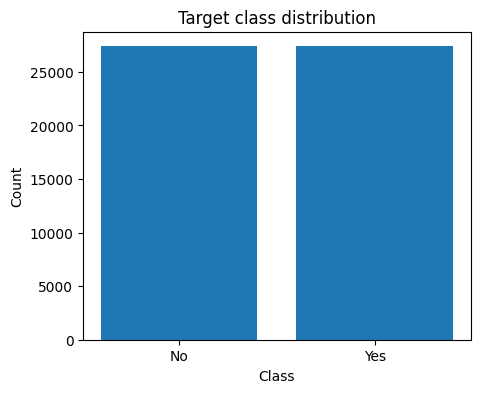

In [23]:
# Downsample majority class to create a balanced dataframe without modifying existing variables
from sklearn.utils import resample
import pandas as pd

# Work off the current df and target_col without changing them
_label = df[target_col]
# Create a temporary binary view that supports either 0/1 or 'No'/'Yes' labels
if _label.dtype == 'object':
    _ybin = _label.map({'No': 0, 'Yes': 1})
else:
    _ybin = _label

# Identify majority/minority using the intended 0 (negative) and 1 (positive) convention
majority = df[_ybin == 0]
minority = df[_ybin == 1]

print("Before balancing:", len(majority), len(minority))

# Guard against edge cases
if len(minority) == 0 or len(majority) == 0:
    print("Cannot downsample: one of the classes has zero samples.")
else:
    # Downsample majority to match minority count
    majority_down = resample(
        majority,
        replace=False,               # no replacement (we're removing)
        n_samples=len(minority),     # make it same as minority
        random_state=42
    )

    # Combine and shuffle to create a balanced dataset copy
    df = pd.concat([majority_down, minority])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print("After balancing:")
    print(df[target_col].value_counts())

counts = df[target_col].value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title('Target class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Note: This cell defines df_balanced only; it does not alter df, X/y, or any pipelines.


In [24]:
# Cleaning & split
# Drop duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print('Dropped', before-after, 'duplicates')

X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Map target labels to numerical values
if y.dtype == 'object':
    y = y.map({'No': 0, 'Yes': 1})
    print("Mapped target labels to numerical values: 0='No', 1='Yes'")
    
    

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)
X_train.sample(10)

Dropped 356 duplicates
Mapped target labels to numerical values: 0='No', 1='Yes'
Train/Test shapes: (43512, 17) (10878, 17)


,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
29774,30.42,No,No,No,4.0,0.0,No,Female,65-69,White,"No, borderline diabetes",Yes,Good,7.0,No,No,No
51670,28.97,Yes,Yes,No,30.0,0.0,Yes,Male,70-74,White,No,No,Fair,7.0,No,No,No
37258,30.67,No,No,No,0.0,2.0,No,Female,55-59,White,No,Yes,Very good,7.0,No,No,No
35442,27.37,Yes,No,No,30.0,0.0,Yes,Male,70-74,White,Yes,Yes,Poor,8.0,Yes,Yes,No
44067,25.09,Yes,No,No,0.0,30.0,No,Male,60-64,White,No,Yes,Excellent,8.0,No,No,No
33457,39.87,No,No,No,0.0,0.0,No,Female,65-69,Other,Yes,Yes,Very good,8.0,No,No,No
10600,32.11,No,No,No,4.0,0.0,No,Male,55-59,White,No,Yes,Fair,5.0,No,No,Yes
48471,32.98,No,No,No,0.0,0.0,No,Male,50-54,White,No,Yes,Very good,6.0,No,No,No
17625,22.81,Yes,No,No,0.0,0.0,No,Male,75-79,White,No,Yes,Very good,6.0,No,No,No
48244,35.67,No,No,No,0.0,0.0,No,Female,65-69,White,Yes,Yes,Good,6.0,No,No,No


In [25]:
# Preprocessor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()
print('num_cols', num_cols)
print('cat_cols', cat_cols)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])


preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols), 
    ('cat', cat_transformer, cat_cols)])

preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_res = preprocessor.transform(X_train)
y_res = y_train.values
print('Preprocessor fitted. Transformed feature count:', preprocessor.transform(X_train).shape[1])

num_cols ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
cat_cols ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Preprocessor fitted. Transformed feature count: 50
Preprocessor fitted. Transformed feature count: 50


In [26]:
# # SMOTE resampling (if imblearn available)
# from collections import Counter
# print('Before:', Counter(y_train))
# try:
#     from imblearn.over_sampling import SMOTE
#     X_train_trans = preprocessor.transform(X_train)
#     sm = SMOTE(random_state=42)
#     X_res, y_res = sm.fit_resample(X_train_trans, y_train)
#     print('After SMOTE:', Counter(y_res))
#     smote_used = True
# except Exception as e:
#     print('SMOTE not available or failed:', e)
#     X_res = preprocessor.transform(X_train)
#     y_res = y_train.values
#     smote_used = False

# print('X_res shape:', X_res.shape)


In [27]:
# Baseline CV for multiple models
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'KNeighbors': KNeighborsClassifier()
}
def Train(name , model):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    results = []
    try:
        # scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='f1')
        # print(name, 'F1:', np.round(scores,4), 'mean=', np.round(scores.mean(),4))
        # results.append({'model': name, 'f1_mean': float(scores.mean())})
        
        prec_scores = cross_val_score(model, X_res, y_res, cv=cv, scoring='precision',n_jobs=-1)
        print(name, 'Precision:', np.round(prec_scores, 4), 'mean=', np.round(prec_scores.mean(), 4))
        results.append({'model': name, 'precision_mean': float(prec_scores.mean())})
        
    except Exception as e:
        print('Failed', name, e)

    pd.DataFrame(results).sort_values('precision_mean', ascending=False)


In [28]:
#Logistic Regression

Train('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42))    

Logistic Regression Precision: [0.7524 0.7601 0.7575] mean= 0.7567


In [29]:
#random Forest
Train('Random Forest', RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=-1))

Random Forest Precision: [0.7221 0.7284 0.7241] mean= 0.7249


In [30]:
#gradient Boosting
Train('Gradient Boosting', GradientBoostingClassifier(n_estimators=200, random_state=42))

Gradient Boosting Precision: [0.7504 0.7546 0.7499] mean= 0.7516


In [31]:
#Hist Gradient Boosting
Train('Hist Gradient Boosting', HistGradientBoostingClassifier(random_state=42))

Hist Gradient Boosting Precision: [0.7455 0.7477 0.7424] mean= 0.7452


In [32]:
#SVC
# Train('SVC', SVC(probability=True, random_state=42))

In [33]:
#KNeighbors
Train('KNeighbors', KNeighborsClassifier())

KNeighbors Precision: [0.7153 0.7187 0.7206] mean= 0.7182


In [34]:
# Hyperparameter tuning with RandomizedSearchCV for RandomForest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_param_dist = {
    'n_estimators': [100,200,400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'class_weight': [None, 'balanced']
}

try:
    rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=20, scoring='precision', cv=cv, random_state=42, n_jobs=-1)
    rf_search.fit(X_res, y_res)
    print('Best RF score:', rf_search.best_score_)
    print('Best RF params:', rf_search.best_params_)
    best_rf = rf_search.best_estimator_
except Exception as e:
    print('RF tuning failed:', e)
    best_rf = None


Best RF score: 0.7527757621282863
Best RF params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': None}


In [35]:
# Final evaluation of best RF on test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

final_results = []
if best_rf is not None:
    try:
        X_test_trans = preprocessor.transform(X_test)
        y_pred = best_rf.predict(X_test_trans)
        y_proba = best_rf.predict_proba(X_test_trans)[:,1] if hasattr(best_rf, 'predict_proba') else None
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        print('RF test accuracy:', acc)
        print('RF test precision:', prec)
        print('RF test recall:', rec)
        print('RF test f1:', f1)
        print('RF test roc:', roc)
        print('Confusion matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('Classification report:')
        print(classification_report(y_test, y_pred, zero_division=0))
        final_results.append({'model': 'RandomForest', 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})
    except Exception as e:
        print('Final evaluation failed', e)
else:
    print('No tuned RF available to evaluate')

import pandas as pd
pd.DataFrame(final_results)


RF test accuracy: 0.746276889134032
RF test precision: 0.74935161170804
RF test recall: 0.741929567131328
RF test f1: 0.7456221198156682
RF test roc: 0.8263514418904765
Confusion matrix:
[[4073 1353]
 [1407 4045]]
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      5426
           1       0.75      0.74      0.75      5452

    accuracy                           0.75     10878
   macro avg       0.75      0.75      0.75     10878
weighted avg       0.75      0.75      0.75     10878



,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.746277,0.749352,0.74193,0.745622,0.826351


In [36]:
# Save best model and results if available
from pathlib import Path
import joblib
models_dir = Path('improved_models')
models_dir.mkdir(parents=True, exist_ok=True)
if best_rf is not None:
    try:
        joblib.dump(best_rf, models_dir / 'best_random_forest_undersampling.joblib')
        print('Saved best_random_forest.joblib')
    except Exception as e:
        print('Saving failed', e)

# Save results CSV
try:
    pd.DataFrame(final_results).to_csv('improved_model_results_summary.csv', index=False)
    print('Saved improved_model_results_summary.csv')
except Exception as e:
    print('Saving results failed', e)


Saved best_random_forest.joblib
Saved improved_model_results_summary.csv


In [37]:
# Hyperparameter tuning for Gradient Boosting and Logistic Regression + evaluation
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ----- Gradient Boosting -----
gb = GradientBoostingClassifier(random_state=42)
gb_param_dist = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.85, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_gb = None
try:
    gb_search = RandomizedSearchCV(
        gb, gb_param_dist, n_iter=20, scoring='precision', cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    gb_search.fit(X_res, y_res)
    print('Best GB score:', gb_search.best_score_)
    print('Best GB params:', gb_search.best_params_)
    best_gb = gb_search.best_estimator_
except Exception as e:
    print('GB tuning failed:', e)

# ----- Logistic Regression -----
lr = LogisticRegression(max_iter=2000, random_state=42)
lr_param_dist = {
    'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'solver': ['lbfgs', 'liblinear', 'saga'],  # all support L2
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}

best_lr = None
try:
    lr_search = RandomizedSearchCV(
        lr, lr_param_dist, n_iter=20, scoring='precision', cv=cv, random_state=42, n_jobs=-1, verbose=1
    )
    lr_search.fit(X_res, y_res)
    print('Best LR score:', lr_search.best_score_)
    print('Best LR params:', lr_search.best_params_)
    best_lr = lr_search.best_estimator_
except Exception as e:
    print('LR tuning failed:', e)

# ----- Evaluation on test set -----
try:
    X_test_trans = preprocessor.transform(X_test)
except Exception as e:
    print('Preprocessor transform failed on X_test:', e)
    X_test_trans = None

# Ensure final_results exists for aggregation
try:
    final_results
except NameError:
    final_results = []

for name, model in [('GradientBoosting', best_gb), ('LogisticRegression', best_lr)]:
    if model is None:
        print(f'No tuned {name} available to evaluate')
        continue
    try:
        # Predict using transformed test features
        y_pred = model.predict(X_test_trans)
        y_proba = model.predict_proba(X_test_trans)[:, 1] if hasattr(model, 'predict_proba') else None
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
        print(f'\n{name} test accuracy:', acc)
        print(f'{name} test precision:', prec)
        print(f'{name} test recall:', rec)
        print(f'{name} test f1:', f1)
        print(f'{name} test roc:', roc)
        print('Confusion matrix:')
        print(confusion_matrix(y_test, y_pred))
        print('Classification report:')
        print(classification_report(y_test, y_pred, zero_division=0))
        final_results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc})
    except Exception as e:
        print(f'Final evaluation failed for {name}:', e)

# Optional: show aggregated results
try:
    import pandas as pd
    display(pd.DataFrame(final_results))
except Exception:
    pass


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best GB score: 0.7596096720642936
Best GB params: {'subsample': 1.0, 'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 2, 'learning_rate': 0.01}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best GB score: 0.7596096720642936
Best GB params: {'subsample': 1.0, 'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 2, 'learning_rate': 0.01}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LR score: 0.7632409567615648
Best LR params: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}

GradientBoosting test accuracy: 0.7449898878470307
GradientBoosting test precision: 0.7558272831486434
GradientBoosting test recall: 0.7256052824651504
GradientBoosting test f1: 0.7404080104810031
GradientBoosting test roc: 0.8241812268258667
Confusion matrix:
[[4148 1278]
 [1496 3956]]
Classification report:
              precision

,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.746277,0.749352,0.741930,0.745622,0.826351
1,GradientBoosting,0.744990,0.755827,0.725605,0.740408,0.824181
2,LogisticRegression,0.761629,0.761478,0.763573,0.762524,0.836636


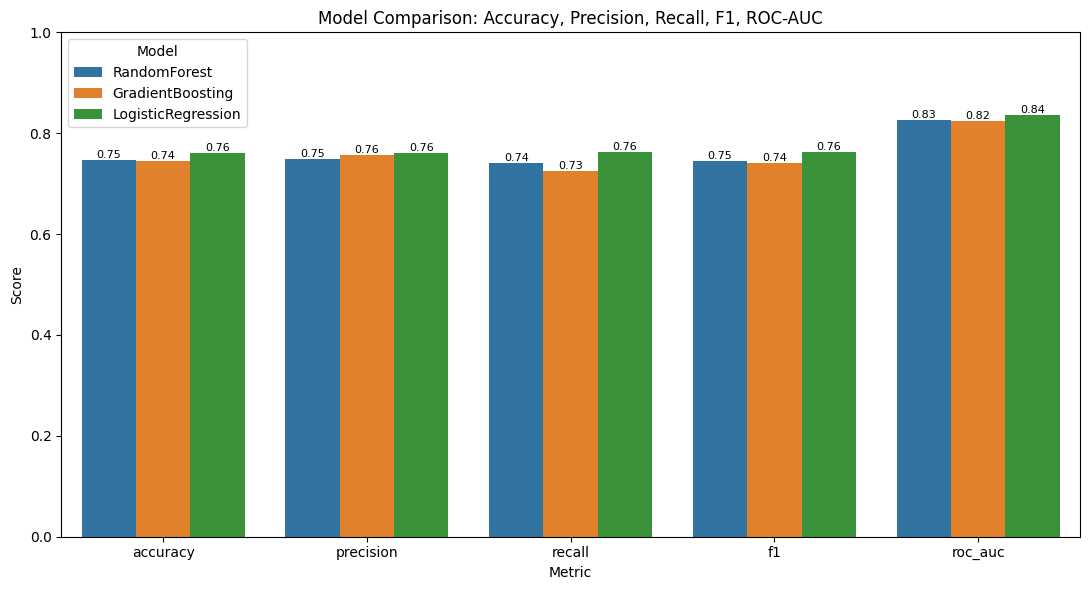

,accuracy,precision,recall,f1,roc_auc
model,,,,,
RandomForest,0.746277,0.749352,0.741930,0.745622,0.826351
GradientBoosting,0.744990,0.755827,0.725605,0.740408,0.824181
LogisticRegression,0.761629,0.761478,0.763573,0.762524,0.836636


In [38]:
# Visualization: Compare metrics across tuned models (RF, GB, LR)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Attempt to use the aggregated results produced earlier
try:
    df_metrics = pd.DataFrame(final_results)
except NameError:
    df_metrics = None

if df_metrics is None or df_metrics.empty:
    print("No metrics available to plot. Run the tuning/evaluation cells first to populate `final_results`.")
else:
    # Focus on the three requested models
    keep_models = ['RandomForest', 'GradientBoosting', 'LogisticRegression']
    df_plot = df_metrics[df_metrics['model'].isin(keep_models)].copy()

    # Ensure all expected metric columns exist
    metrics_cols = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for c in metrics_cols:
        if c not in df_plot.columns:
            df_plot[c] = None

    # If nothing remains after filtering, inform the user
    if df_plot.empty:
        print("Expected models not found in results. Available models:", sorted(df_metrics['model'].unique()))
    else:
        # Melt for grouped bar plotting
        df_long = df_plot.melt(id_vars='model', value_vars=metrics_cols, var_name='metric', value_name='value')
        df_long = df_long.dropna(subset=['value'])

        if df_long.empty:
            print("Metrics are missing (all NaN). Ensure evaluation cells computed accuracy/precision/recall/f1/roc_auc.")
        else:
            plt.figure(figsize=(11, 6))
            ax = sns.barplot(data=df_long, x='metric', y='value', hue='model')
            ax.set_ylim(0, 1.0)
            ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1, ROC-AUC')
            ax.set_xlabel('Metric')
            ax.set_ylabel('Score')
            # Add value labels on bars
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', fontsize=8)
            ax.legend(title='Model', loc='best')
            plt.tight_layout()
            plt.show()

            # Also display the numeric table for reference
            display(df_plot.set_index('model')[metrics_cols])


In [39]:
# Save tuned Logistic Regression and Gradient Boosting models
from pathlib import Path
import joblib

models_dir = Path('improved_models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save Logistic Regression
if best_lr is not None:
    try:
        joblib.dump(best_lr, models_dir / 'best_logistic_regression_undersampling.joblib')
        print('Saved best_logistic_regression_undersampling.joblib')
    except Exception as e:
        print('Saving Logistic Regression failed:', e)
else:
    print('No tuned Logistic Regression model available to save')

# Save Gradient Boosting
if best_gb is not None:
    try:
        joblib.dump(best_gb, models_dir / 'best_gradient_boosting_undersampling.joblib')
        print('Saved best_gradient_boosting_undersampling.joblib')
    except Exception as e:
        print('Saving Gradient Boosting failed:', e)
else:
    print('No tuned Gradient Boosting model available to save')

print(f'\nAll models saved to: {models_dir.absolute()}')


Saved best_logistic_regression_undersampling.joblib
Saved best_gradient_boosting_undersampling.joblib

All models saved to: /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/improved_models


In [40]:
# Save the preprocessor for deployment (Streamlit app needs this!)
from pathlib import Path
import joblib

# Save preprocessor to the final1.0 directory for the Streamlit app
deployment_dir = Path('../final1.0')
deployment_dir.mkdir(parents=True, exist_ok=True)

try:
    joblib.dump(preprocessor, deployment_dir / 'preprocessor.joblib')
    print(f'Saved preprocessor to: {(deployment_dir / "preprocessor.joblib").absolute()}')
    
    # Also copy the best LogisticRegression model to deployment directory as LRM.joblib
    if best_lr is not None:
        joblib.dump(best_lr, deployment_dir / 'LRM.joblib')
        print(f'Saved LRM.joblib to: {(deployment_dir / "LRM.joblib").absolute()}')
    else:
        print('Warning: best_lr not available, cannot copy to deployment directory')
        
except Exception as e:
    print(f'Failed to save for deployment: {e}')

print("\n✅ Deployment files ready! Run your Streamlit app with:")
print("   cd final1.0 && streamlit run 1.py")


Saved preprocessor to: /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/../final1.0/preprocessor.joblib
Saved LRM.joblib to: /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/../final1.0/LRM.joblib

✅ Deployment files ready! Run your Streamlit app with:
   cd final1.0 && streamlit run 1.py


In [41]:
# Save the fitted preprocessor to disk (for deployment/inference)
from pathlib import Path
import joblib

try:
    # Ensure preprocessor exists
    preprocessor  # noqa: F401
except NameError:
    print("Error: `preprocessor` is not defined. Run the preprocessing cell first.")
else:
    out_paths = []
    # 1) Project-level artifacts folder
    models_dir = Path('improved_models')
    models_dir.mkdir(parents=True, exist_ok=True)
    p1 = models_dir / 'preprocessor.joblib'
    joblib.dump(preprocessor, p1)
    out_paths.append(p1)

    # 2) Streamlit app folder
    app_dir = Path('../final1.0')  # relative to this notebook's draft/ location
    app_dir.mkdir(parents=True, exist_ok=True)
    p2 = app_dir / 'preprocessor.joblib'
    joblib.dump(preprocessor, p2)
    out_paths.append(p2)

    print("Saved preprocessor to:")
    for p in out_paths:
        print(" -", p.resolve())

Saved preprocessor to:
 - /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/improved_models/preprocessor.joblib
 - /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/final1.0/preprocessor.joblib


In [42]:
#Export all models and preprocessors to organized directory structure
#N: Path, joblib and other modules are expected to be already imported earlier in the notebook.
#This cell avoids re-importing to prevent duplicate imports in the notebook context.

#Ensure the export_dir exists (use existing export_dir if defined)
try:
    export_dir  # reference to see if already defined
except NameError:
    from pathlib import Path
    export_dir = Path('exported_models')
    export_dir.mkdir(parents=True, exist_ok=True)
else:
    # use existing export_dir variable but ensure directory exists
    export_dir.mkdir(parents=True, exist_ok=True)

# Safely fetch model and preprocessor objects from the notebook globals (they may not be defined)
models_to_export = [
    ('RandomForest', globals().get('best_rf')),
    ('GradientBoosting', globals().get('best_gb')),
    ('LogisticRegression', globals().get('best_lr')),
]

preprocessor_obj = globals().get('preprocessor')
exported_count = 0
skipped_count = 0

print("=" * 60)
print("EXPORTING MODELS AND PREPROCESSORS")
print("=" * 60)

for model_name, model_obj in models_to_export:
    if model_obj is None:
        print(f"\n⚠️  {model_name}: Skipped (model not trained or variable missing)")
        skipped_count += 1
        continue

    # Create subdirectory for this model
    model_dir = export_dir / model_name
    model_dir.mkdir(parents=True, exist_ok=True)

    try:
        # Save the model (joblib is expected to be imported earlier in the notebook)
        joblib.dump(model_obj, model_dir / 'model.joblib')

        # Save the preprocessor if available
        if preprocessor_obj is not None:
            joblib.dump(preprocessor_obj, model_dir / 'preprocessor.joblib')
            preproc_msg = " + preprocessor.joblib"
        else:
            preproc_msg = " (preprocessor missing, not saved)"

        print(f"\n✅ {model_name}:")
        print(f"   📁 {model_dir.resolve()}")
        print(f"   ├── model.joblib{'' if preproc_msg.startswith(' ') else ''}")
        if preprocessor_obj is not None:
            print(f"   └── preprocessor.joblib")
        else:
            print(f"   └── preprocessor: MISSING - save skipped")

        exported_count += 1

    except Exception as e:
        print(f"\n❌ {model_name}: Export failed - {e}")
        skipped_count += 1

print("\n" + "=" * 60)
print(f"EXPORT SUMMARY: {exported_count} exported, {skipped_count} skipped")
print("=" * 60)
try:
    print(f"\n📂 All exports saved to: {export_dir.resolve()}")
except Exception:
    print("\n📂 All exports saved to: exported_models (path resolution failed)")

print("\n💡 Each model directory contains (if saved):")
print("   • model.joblib - The trained model")
print("   • preprocessor.joblib - Feature preprocessing pipeline (if available)")

print("\n🚀 To use a model in production:")
print("   import joblib")
print("   model = joblib.load('exported_models/<ModelName>/model.joblib')")
print("   preprocessor = joblib.load('exported_models/<ModelName>/preprocessor.joblib')  # if saved")
#Export all models and preprocessors to organized directory structure
# NOTE: Path, joblib and other modules are expected to be already imported earlier in the notebook.
#
# This cell avoids re-importing to prevent duplicate imports in the notebook context.

# Ensure the export_dir exists (use existing export_dir if defined)
try:
    export_dir  # reference to see if already defined
except NameError:
    from pathlib import Path
    export_dir = Path('exported_models')
    export_dir.mkdir(parents=True, exist_ok=True)
else:
    # use existing export_dir variable but ensure directory exists
    export_dir.mkdir(parents=True, exist_ok=True)

# Safely fetch model and preprocessor objects from the notebook globals (they may not be defined)
models_to_export = [
    ('RandomForest', globals().get('best_rf')),
    ('GradientBoosting', globals().get('best_gb')),
    ('LogisticRegression', globals().get('best_lr')),
]

preprocessor_obj = globals().get('preprocessor')
exported_count = 0
skipped_count = 0

print("=" * 60)
print("EXPORTING MODELS AND PREPROCESSORS")
print("=" * 60)

for model_name, model_obj in models_to_export:
    if model_obj is None:
        print(f"\n⚠️  {model_name}: Skipped (model not trained or variable missing)")
        skipped_count += 1
        continue

    # Create subdirectory for this model
    model_dir = export_dir / model_name
    model_dir.mkdir(parents=True, exist_ok=True)

    try:
        # Save the model (joblib is expected to be imported earlier in the notebook)
        joblib.dump(model_obj, model_dir / 'model.joblib')

        # Save the preprocessor if available
        if preprocessor_obj is not None:
            joblib.dump(preprocessor_obj, model_dir / 'preprocessor.joblib')
            preproc_msg = " + preprocessor.joblib"
        else:
            preproc_msg = " (preprocessor missing, not saved)"

        print(f"\n✅ {model_name}:")
        print(f"   📁 {model_dir.resolve()}")
        print(f"   ├── model.joblib{'' if preproc_msg.startswith(' ') else ''}")
        if preprocessor_obj is not None:
            print(f"   └── preprocessor.joblib")
        else:
            print(f"   └── preprocessor: MISSING - save skipped")

        exported_count += 1

    except Exception as e:
        print(f"\n❌ {model_name}: Export failed - {e}")
        skipped_count += 1

print("\n" + "=" * 60)
print(f"EXPORT SUMMARY: {exported_count} exported, {skipped_count} skipped")
print("=" * 60)
try:
    print(f"\n📂 All exports saved to: {export_dir.resolve()}")
except Exception:
    print("\n📂 All exports saved to: exported_models (path resolution failed)")

print("\n💡 Each model directory contains (if saved):")
print("   • model.joblib - The trained model")
print("   • preprocessor.joblib - Feature preprocessing pipeline (if available)")

print("\n🚀 To use a model in production:")
print("   import joblib")
print("   model = joblib.load('exported_models/<ModelName>/model.joblib')")
print("   preprocessor = joblib.load('exported_models/<ModelName>/preprocessor.joblib')  # if saved")


EXPORTING MODELS AND PREPROCESSORS

✅ RandomForest:
   📁 /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/exported_models/RandomForest
   ├── model.joblib
   └── preprocessor.joblib

✅ GradientBoosting:
   📁 /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/exported_models/GradientBoosting
   ├── model.joblib
   └── preprocessor.joblib

✅ LogisticRegression:
   📁 /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/exported_models/LogisticRegression
   ├── model.joblib
   └── preprocessor.joblib

EXPORT SUMMARY: 3 exported, 0 skipped

📂 All exports saved to: /Users/princegondaliya/Learning/Projects/Heartattack_ML/GIt hub/Heartattack_ML/draft/exported_models

💡 Each model directory contains (if saved):
   • model.joblib - The trained model
   • preprocessor.joblib - Feature preprocessing pipeline (if available)

🚀 To use a model in production:
   import joblib
   model = joblib.load('e